# BUILDING ANN for subset of Fashion MNIST , 784 inout -> 126+relu -> 64+relu -> 10+softmax neurons

In [1]:
#basic imports and settings

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
   

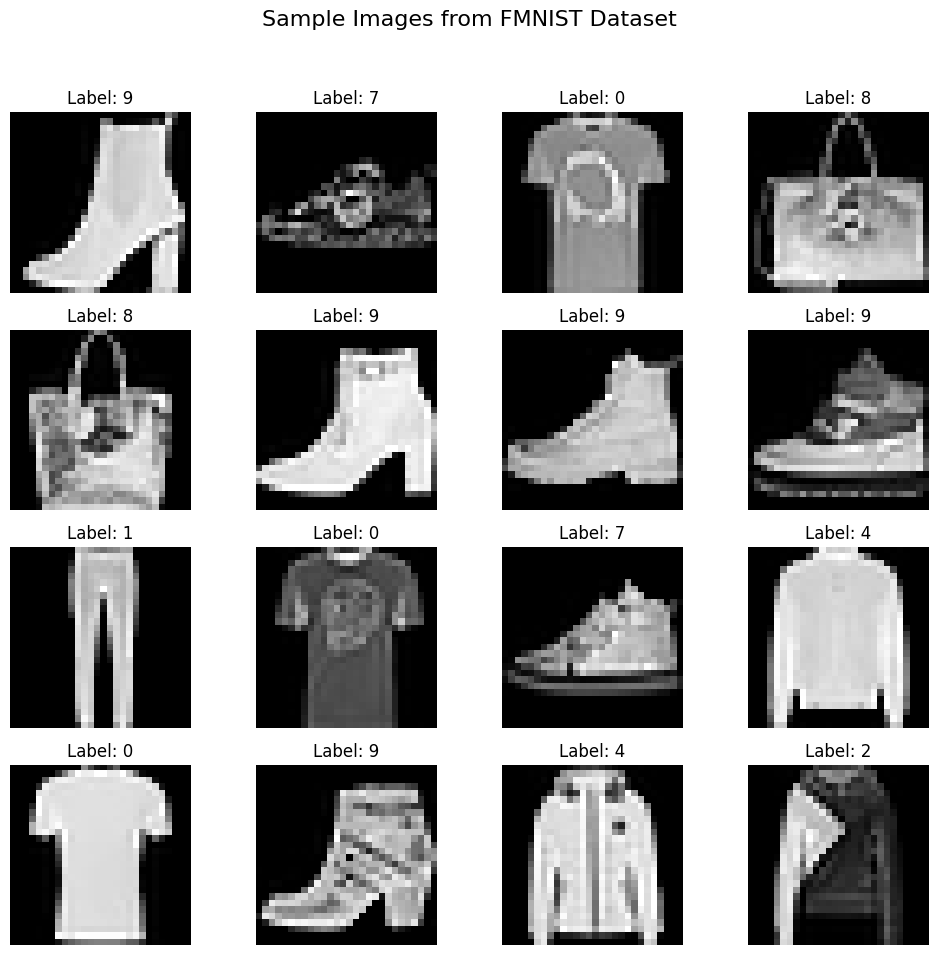

In [2]:
#dataset
df=pd.read_csv('fmnist_small.csv')
df.head()
fig, axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle('Sample Images from FMNIST Dataset', fontsize=16)

#visualization
for i, ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {df.iloc[i,0]}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [3]:
#TRAIN_TEST_SPLIT_AND_SCALING

# train test split
X=df.iloc[:,1:].values
Y=df.iloc[:,0].values

X_train, X_test, Y_train , Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#scaling the features
X_train = X_train / 255.0
X_test = X_test / 255.0


In [4]:
# dataset wrapper
 
class customDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
#dataset object 
train_dataset = customDataset(X_train, Y_train)
test_dataset = customDataset(X_test, Y_test)

#data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# creating our NN
class MyNN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(num_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self,X):
        return self.model(X)
    

# parameters
epochs=100
learning_rate=0.01  # Reduced learning rate for better convergence

#initialize model
model=MyNN(X_train.shape[1])

#move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
model.to(device)

#loss and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate)


In [8]:
# training and loop 

for epoch in range(epochs):

    total_epoch_loss=0.0

    for batch_features,batch_labels in train_loader:

        #forward pass
        outputs=model(batch_features)

        #calculate loss
        loss=loss_fn(outputs,batch_labels)

        #backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #update weights

        total_epoch_loss = total_epoch_loss + loss.item() #accumulate loss 

    avg_loss = total_epoch_loss / len(train_loader) #average loss per epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


Epoch [10/100], Loss: 0.7541
Epoch [20/100], Loss: 0.5649
Epoch [30/100], Loss: 0.4795
Epoch [40/100], Loss: 0.4287
Epoch [50/100], Loss: 0.3929
Epoch [60/100], Loss: 0.3645
Epoch [70/100], Loss: 0.3259
Epoch [80/100], Loss: 0.2976
Epoch [90/100], Loss: 0.2708
Epoch [100/100], Loss: 0.2506


In [ ]:
# Set model to evaluation mode
model.eval()

#evaulation code
total = 0
correct = 0

with torch.no_grad():
    
    for batch_features, batch_labels in test_loader:
        
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features) #forward pass
        _, predicted = torch.max(outputs, 1) #get predictions #_, is there to ignore the first output
        total += batch_labels.shape[0] #total samples
        correct += (predicted == batch_labels).sum().item() #correct predictions

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.8292
